### Convex Quadratic Optimization
$$\min_{x \in R^d} \frac 12 x^T Q x + c^T x$$
subject to
$$l^c \le Ax \le u^c,$$
$$l^x \le x \le u^x$$

### Slab SVM
Let $K \in R^{~n~x~n}$ and $K_{ij} = \texttt{Kernel}(x_i, x_j)$
$$\min_{\alpha \in R^d} \frac 12 \alpha^T K \alpha + [-\delta...-\delta] \alpha$$
subject to
$$1\le [1~...~1]~\alpha \le 1,$$
$$\frac {-1}{vm} \le \alpha_i \le \frac {1}{vm}$$
Evaluation
$$ \sum_i \alpha_i k(x_i,x) - \rho $$

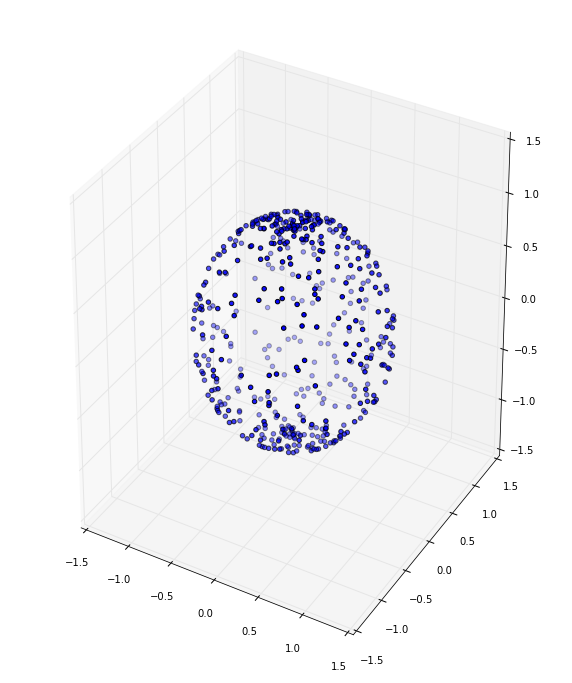

(0,)
(0,)
(0,)
(125000,)
(0,)
(125000,)
(0,)
(0,)
[[[-0.99752446 -0.99709505 -0.99661378 ..., -0.99660856 -0.99709037
   -0.9975203 ]
  [-0.99709508 -0.99659118 -0.99602644 ..., -0.99602031 -0.99658569
   -0.9970902 ]
  [-0.99661385 -0.99602648 -0.99536818 ..., -0.99536104 -0.99602008
   -0.99660816]
  ..., 
  [-0.99661077 -0.99602286 -0.99536397 ..., -0.99535675 -0.99601639
   -0.99660502]
  [-0.99709231 -0.99658794 -0.99602266 ..., -0.99601646 -0.99658239
   -0.99708738]
  [-0.99752201 -0.99709217 -0.99661042 ..., -0.99660514 -0.99708744
   -0.99751781]]

 [[-0.99709512 -0.99659123 -0.9960265  ..., -0.99602037 -0.99658574
   -0.99709024]
  [-0.99659126 -0.99599997 -0.99533729 ..., -0.9953301  -0.99599353
   -0.99658554]
  [-0.99602658 -0.99533734 -0.99456487 ..., -0.99455649 -0.99532982
   -0.99601991]
  ..., 
  [-0.99602297 -0.99533309 -0.99455992 ..., -0.99455145 -0.9953255
   -0.99601622]
  [-0.99658803 -0.99599617 -0.99533285 ..., -0.99532559 -0.99598966
   -0.99658224]
  [-0.997

In [15]:
%matplotlib inline

import numpy as np
from numpy import linalg, random, ones, zeros
from sklearn.cross_validation import train_test_split
import mosek
import math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import sys


# Define a stream printer to grab output from MOSEK
def streamprinter(text):
#     sys.stdout.write(text)
#     sys.stdout.flush()
    pass


sigma = 100
def kernel(x1,x2):
    return math.exp(-1*math.pow(linalg.norm(x1-x2),2)/(2*math.pow(sigma,
                                                                  2)))

rho = 1
def f(x,x_list,alpha):
    w=0
    for i in range(len(x_list)):
        w = w + (alpha[i]*kernel(x_list[i],x))
    return w - rho


x = []

r=1
points = random.random((500,2))*2*np.pi
# print points
for p in range(len(points)):
    z_cord = r * np.sin(points[p][1])
    
    r_temp = r * np.cos(points[p][1])
    y_cord = r_temp * np.sin(points[p][0])
    x_cord = r_temp * np.cos(points[p][0])
    
    x.append([x_cord, y_cord, z_cord])
    
x = np.asarray(x)

for i in range(x.shape[0]):
    x_cord = x[i][0]
    y_cord = x[i][1]
    z_cord = x[i][2]

    if abs(x_cord**2 + y_cord**2 + z_cord**2 - r**2)>0.01:
        assert False

fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2])
plt.show()

x=x.astype(np.float)
y = np.ones(len(x))
m = len(x)
# print 'points:',m
# x,ignore_x,y,ignore_y=train_test_split(
#                x,y,train_size=0.02,random_state=8)
m = len(x)

# x0_max = np.amax(x[:,0])+0.1
# x0_min = np.amin(x[:,0])-0.1
# x1_max = np.amax(x[:,1])+0.1
# x1_min = np.amin(x[:,1])-0.1
# x2_max = np.amax(x[:,2])+0.1
# x2_min = np.amin(x[:,2])-0.1

# print x0_max 
# print x0_min 
# print x1_max 
# print x1_min 
# print x2_max 
# print x2_min 

# print 'points:',m

# overfit/underfit param
v=.99

# Open MOSEK and create an environment and task
# Make a MOSEK environment
env = mosek.Env ()
# Attach a printer to the environment
env.set_Stream (mosek.streamtype.log, streamprinter)
# Create a task
task = env.Task()
task.set_Stream (mosek.streamtype.log, streamprinter)
# Set up and input bounds and linear coefficients
bkc   = [ mosek.boundkey.fx]
blc   = [ 1.0 ]
buc   = [ 1.0 ]

bkx=[]
for i in range(m):
    bkx.append(mosek.boundkey.ra)
bux=(ones((m))) * (1/(v*m))
blx=(ones((m))) * (-1/(v*m))
delta = 0.1
c=(delta*ones((m)))

numvar = len(bkx)
numcon = len(bkc)

# Append 'numcon' empty constraints.
# The constraints will initially have no bounds.
task.appendcons(numcon)

# Append 'numvar' variables.
# The variables will initially be fixed at zero (x=0).
task.appendvars(numvar)

for j in range(numvar):
    # Set the linear term c_j in the objective.
    task.putcj(j,c[j])
    # Set the bounds on variable j
    # blx[j] <= x_j <= bux[j]
    task.putbound(mosek.accmode.var,j,bkx[j],blx[j],bux[j])

    # Input i, j of A
    task.putaij(0, j, 1)

for i in range(numcon):
    task.putbound(mosek.accmode.con,i,bkc[i],blc[i],buc[i])

# Input the objective sense (minimize/maximize)
task.putobjsense(mosek.objsense.maximize)

# Set up and input quadratic objective
for i in range(m):
    for j in range(i+1):
        task.putqobjij(i,j,kernel(x[i],x[j]))

task.putobjsense(mosek.objsense.minimize)

# Optimize
task.optimize()
# Print a summary containing information
# about the solution for debugging purposes
task.solutionsummary(mosek.streamtype.msg)

prosta = task.getprosta(mosek.soltype.itr)
solsta = task.getsolsta(mosek.soltype.itr)

# Output a solution
xx = zeros(numvar, float)
task.getxx(mosek.soltype.itr, xx)

# if solsta == mosek.solsta.optimal or solsta == mosek.solsta.near_optimal:
#     print("Optimal solution: %s" % xx)
# elif solsta == mosek.solsta.dual_infeas_cer:
#     print("Primal or dual infeasibility.\n")
# elif solsta == mosek.solsta.prim_infeas_cer:
#     print("Primal or dual infeasibility.\n")
# elif solsta == mosek.solsta.near_dual_infeas_cer:
#     print("Primal or dual infeasibility.\n")
# elif  solsta == mosek.solsta.near_prim_infeas_cer:
#     print("Primal or dual infeasibility.\n")
# elif mosek.solsta.unknown:
#     print("Unknown solution status")
# else:
#     print("Other solution status")

alpha = xx

num_steps = 50
x0_range = np.linspace(-200, 200,num_steps)
x1_range = np.linspace(-200, 200,num_steps)
x2_range = np.linspace(-200, 200,num_steps)

data = np.zeros((num_steps,num_steps,num_steps))

for i in range(num_steps):
    for j in range(num_steps):
        for k in range(num_steps):
            x_temp = np.asarray([x0_range[i],
                                x1_range[j],
                                x2_range[k]])
            data[i,j,k] = f(x_temp,x,alpha)
            
print (np.where(np.abs(data - delta) < .01)[0].shape)
print (np.where(np.abs(data - delta) < .001)[0].shape)
print (np.where(np.abs(data - delta) < .0001)[0].shape)
print (np.where(data < delta )[0].shape)
print (np.where(data > delta )[0].shape)
print (np.where( data < 0)[0].shape)
print (np.where( data == 0)[0].shape)
print (np.where( data > 0)[0].shape)
print data


In [16]:
num_steps = 100
x0_range = np.linspace(-200, 200,num_steps)
x1_range = np.linspace(-200, 200,num_steps)
x2_range = np.linspace(-200, 200,num_steps)

data = np.zeros((num_steps,num_steps,num_steps))

for i in range(num_steps):
    for j in range(num_steps):
        for k in range(num_steps):
            x_temp = np.asarray([x0_range[i],
                                x1_range[j],
                                x2_range[k]])
            data[i,j,k] = f(x_temp,x,alpha)
            
print (np.where(np.abs(data - delta) < .01)[0].shape)
print (np.where(np.abs(data - delta) < .001)[0].shape)
print (np.where(np.abs(data - delta) < .0001)[0].shape)
print (np.where(data < delta )[0].shape)
print (np.where(data > delta )[0].shape)
print (np.where( data < 0)[0].shape)
print (np.where( data == 0)[0].shape)
print (np.where( data > 0)[0].shape)
print data


(0,)
(0,)
(0,)
(1000000,)
(0,)
(1000000,)
(0,)
(0,)
[[[-0.99752446 -0.99731827 -0.99709964 ..., -0.99709497 -0.99731386
   -0.9975203 ]
  [-0.99731828 -0.99709491 -0.99685808 ..., -0.99685301 -0.99709013
   -0.99731378]
  [-0.99709967 -0.99685809 -0.99660195 ..., -0.99659647 -0.99685292
   -0.9970948 ]
  ..., 
  [-0.99709691 -0.99685511 -0.99659872 ..., -0.99659318 -0.99684988
   -0.99709199]
  [-0.99731568 -0.99709209 -0.99685503 ..., -0.99684991 -0.99708726
   -0.99731113]
  [-0.99752201 -0.99731561 -0.99709676 ..., -0.99709204 -0.99731115
   -0.99751781]]

 [[-0.9973183  -0.99709494 -0.9968581  ..., -0.99685304 -0.99709016
   -0.9973138 ]
  [-0.99709495 -0.99685298 -0.99659642 ..., -0.99659094 -0.99684781
   -0.99709007]
  [-0.99685813 -0.99659644 -0.99631896 ..., -0.99631303 -0.99659084
   -0.99685286]
  ..., 
  [-0.99685515 -0.9965932  -0.99631546 ..., -0.99630947 -0.99658754
   -0.99684981]
  [-0.99709213 -0.99684993 -0.99659312 ..., -0.99658757 -0.99684469
   -0.9970872 ]
  [-0.